# MNIST - CNN

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = np.genfromtxt('train.csv', delimiter=',',skip_header=1)
data.shape

(42000, 785)

**Extra preparation of data for the ResNet (must be chromatic and minimum size is 32x32)**

In [3]:
# normalize X
X = data[:,1:]/255
X = X.reshape(-1,28,28)
# pad with zeros
pad = np.zeros((len(X),2,28))
X = np.hstack([pad,X,pad])
pad = np.zeros((len(X),32,2))
X = np.dstack([pad,X,pad])

In [4]:
# normalize X
X = data[:,1:]/255
X = X.reshape(-1,28,28)
# pad with zeros
pad = np.zeros((len(X),2,28))
X = np.hstack([pad,X,pad])
pad = np.zeros((len(X),32,2))
X = np.dstack([pad,X,pad])
# make X chromatic (cheap trick that seems to be good enough here)
X = np.stack([X,X,X],axis=3)
# one hot encode y
y = np.zeros(shape=(len(X),10),dtype=int)
y[np.arange(len(data)),data[:,0].astype(int)] = 1
X.shape,y.shape

((42000, 32, 32, 3), (42000, 10))

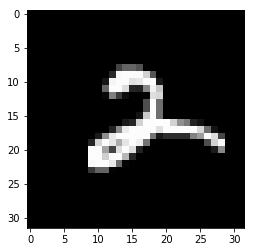

(2, array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0]))

In [5]:
# sample image
i = np.random.randint(len(X))
plt.imshow(X[i])
plt.show()
np.argmax(y[i]),y[i]

In [6]:
# train/test split
mask = np.zeros(shape=len(X),dtype=bool)
mask[np.random.choice(np.arange(len(X)),size=int(0.8*len(X)),replace=False)] = 1
X_train = X[mask]
X_test = X[~mask]
y_train = y[mask]
y_test = y[~mask]

In [8]:
# check balance
np.unique(np.argmax(y_train,axis=1),return_counts=True)[1]

array([3284, 3751, 3370, 3510, 3258, 3001, 3329, 3509, 3293, 3295])

In [9]:
np.unique(np.argmax(y_test,axis=1),return_counts=True)[1]

array([848, 933, 807, 841, 814, 794, 808, 892, 770, 893])

### ResNet-based model

In [10]:
from keras.models import Model
from keras.layers import Dense, Flatten, Dropout
from keras.applications.resnet50 import ResNet50

In [11]:
resnet = ResNet50(input_shape=(32,32,3),include_top=False)
# do not train the pre-trained ResNet
for layer in resnet.layers:
    layer.trainable = False

/home/raphael/Software/anaconda3/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 11s 0us/step


In [13]:
# add output layer
dense = Dense(256, activation='relu')(Flatten()(resnet.output))
drop = Dropout(rate=0.5)(dense)
output = Dense(10, activation='softmax')(drop)

model = Model(inputs=resnet.input, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy',
              metrics=['accuracy'])

### Training

In [14]:
model.fit(X_train,y_train,epochs=10)

Epoch 1/10
33600/33600 [==============================] - 379s 11ms/step - loss: 0.1600 - acc: 0.9425
Epoch 2/10
33600/33600 [==============================] - 333s 10ms/step - loss: 0.1267 - acc: 0.9539
Epoch 3/10
33600/33600 [==============================] - 338s 10ms/step - loss: 0.1155 - acc: 0.9578
Epoch 4/10
33600/33600 [==============================] - 390s 12ms/step - loss: 0.1106 - acc: 0.9592
Epoch 5/10
33600/33600 [==============================] - 364s 11ms/step - loss: 0.1089 - acc: 0.9601
Epoch 6/10
33600/33600 [==============================] - 333s 10ms/step - loss: 0.1068 - acc: 0.9610
Epoch 7/10
33600/33600 [==============================] - 333s 10ms/step - loss: 0.1051 - acc: 0.9620
Epoch 8/10
33600/33600 [==============================] - 333s 10ms/step - loss: 0.1029 - acc: 0.9628
Epoch 9/10
33600/33600 [==============================] - 378s 11ms/step - loss: 0.1024 - acc: 0.9628
Epoch 10/10
33600/33600 [==============================] - 356s 11ms/step - loss: 

### Scoring

In [15]:
model.evaluate(X_train,y_train)

33600/33600 [==============================] - 291s 9ms/step


[1.1457686288016182, 0.8208869635491144]

In [16]:
model.evaluate(X_test,y_test)

8400/8400 [==============================] - 67s 8ms/step


[1.136466794013977, 0.8212381516184125]

That is rather strange

In [17]:
# alternative
from keras.applications.inception_v3 import InceptionV3